# Warszaty badawcze Praca domowa 4

## Mateusz Flis, Przemysław Olender, Tomasz Modzelewski

## Dane tabularyczne

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import PIL.Image
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import pytesseract

import os
import re
import cv2

from wordcloud import WordCloud, STOPWORDS
from textstat import lexicon_count
from textstat import flesch_reading_ease
from textstat import flesch_kincaid_grade
from textstat import sentence_count
from textstat import lexicon_count
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import *
from spacy.lang.en import English
import spacy
from spacy.lang.en.examples import sentences 
import en_core_web_md

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from copy import deepcopy
import skimage.transform
from gzip import open as gzopen
import nibabel as nib

C:\Users\DamnBoii\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


## 1. covid 19 segmentation dataset

In [63]:
covidsegmentationdataset = pd.read_csv("Test-Images-Clinical-Details.csv")
covidsegmentationdataset

,SIRM Case,Slice position in .nii.gz,Patient age,Patient Sex (Male = 0 Female = 1),Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1,60.0,80.0,0.0,NaN,NaN,NaN
1,2,2.0,62.0,0.0,NaN,NaN,NaN
2,2,89.0,NaN,NaN,NaN,NaN,NaN
3,3,72.0,57.0,0.0,NaN,NaN,NaN
4,3,70.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Usuwamy zbędne kolumny oraz wiersze

In [64]:
covidsegmentationdataset = covidsegmentationdataset.drop(columns=["Unnamed: 4","Unnamed: 5",
                                                                  "Unnamed: 6"])
covidsegmentationdataset

,SIRM Case,Slice position in .nii.gz,Patient age,Patient Sex (Male = 0 Female = 1)
0,1,60.0,80.0,0.0
1,2,2.0,62.0,0.0
2,2,89.0,NaN,NaN
3,3,72.0,57.0,0.0
4,3,70.0,NaN,NaN
...,...,...,...,...
101,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN


In [65]:
covidsegmentationdataset = covidsegmentationdataset[covidsegmentationdataset['SIRM Case'].notnull()]
covidsegmentationdataset = covidsegmentationdataset.iloc[:-1]
covidsegmentationdataset

,SIRM Case,Slice position in .nii.gz,Patient age,Patient Sex (Male = 0 Female = 1)
0,1,60.0,80.0,0.0
1,2,2.0,62.0,0.0
2,2,89.0,NaN,NaN
3,3,72.0,57.0,0.0
4,3,70.0,NaN,NaN
...,...,...,...,...
95,47,69.0,61.0,0.0
96,47,96.0,NaN,NaN
97,47,51.0,NaN,NaN
98,49,1.0,84.0,0.0


Zastąpienie NaN 

In [66]:
sex = ""
age = 0
df = covidsegmentationdataset
x = float('nan')
for i in range(len(df)):
    if  not np.isnan(df.loc[i,'Patient age']):
        age = df.loc[i,'Patient age']
    else:
        df.loc[i,'Patient age'] = age
    if not np.isnan(df.loc[i,'Patient Sex (Male = 0 Female = 1)']):
        sex = df.loc[i,'Patient Sex (Male = 0 Female = 1)']
    else:
        df.loc[i,'Patient Sex (Male = 0 Female = 1)'] = sex
 

df

,SIRM Case,Slice position in .nii.gz,Patient age,Patient Sex (Male = 0 Female = 1)
0,1,60.0,80.0,0.0
1,2,2.0,62.0,0.0
2,2,89.0,62.0,0.0
3,3,72.0,57.0,0.0
4,3,70.0,57.0,0.0
...,...,...,...,...
95,47,69.0,61.0,0.0
96,47,96.0,61.0,0.0
97,47,51.0,61.0,0.0
98,49,1.0,84.0,0.0


W tej bazie usunęliśmy braki danych we wszystkich kolumnach i zostawiliśmy jedynie identyfikującą kolumny oraz informacje o płci i wieku.

## 2. China Dataset

In [13]:
content = []
src_china_txt = "./ClinicalReadings/"
import os
for (dirpath, dirnames, filenames) in os.walk(src_china_txt):
    filenames = filenames
for filename in filenames:
    with open(src_china_txt + filename, mode = 'r') as f:
        content.append([filename.split('_')[1], f.read()])
df_china = pd.DataFrame(content, columns = ['id', 'content'])
df_china['content'] = df_china['content'].str.lower()
df_china

,id,content
0,0001,male 45yrs\nnormal
1,0002,male 63yrs\nnormal
2,0003,female 48yrs\nnormal
3,0004,male 58yrs \nnormal
4,0005,male 28yrs\nnormal
...,...,...
657,0658,male 41yrs \t\nbilateral secondary ptb with ...
658,0659,"male , 33yrs \t\nsecondary ptb in the left u..."
659,0660,"male , 50yrs \t\n1.bilateral secondary ptb w..."
660,0661,"male, 26yrs \t\nbilateral secondary ptb with..."


Poprawiamy błędy z napisami.

In [14]:
df_china['content'] = df_china['content'].str.replace('femal ', 'female ')

In [24]:
def sex_to_str(sex):
    if type(sex) != type([]): return np.nan
    if len(sex) == 0: return np.nan
    return sex[0]

sexes = df_china['content'].str.findall(r"(female|male)").apply(sex_to_str).dropna()
sexes.value_counts()

male      449
female    213
Name: content, dtype: int64

In [18]:
def yrs_to_int(yrs):
    if type(yrs) != type([]): return np.nan
    if len(yrs) == 0: return np.nan
    return yrs[0].replace('yrs', '')

ages = df_china['content'].str.findall(r"[0-9]*yrs").apply(yrs_to_int).dropna()
ages = ages[ages != ""].astype('int')
ages

0      45
1      63
2      48
3      58
4      28
       ..
657    41
658    33
659    50
660    26
661    32
Name: content, Length: 652, dtype: int32

In [115]:
def sick(yrs):
    if type(yrs) != type([]): return np.nan
    if len(yrs) == 0: return np.nan
    x = yrs[0].replace('\n', '')
    return x!='normal'

sick = df_china['content'].str.findall(r"\n.*").apply(sick).dropna()
sick = sick[sick != ""].astype('int')
sick

0      0
1      0
2      1
3      0
4      0
      ..
657    1
658    1
659    1
660    1
661    1
Name: content, Length: 662, dtype: int32

In [116]:
ides = np.array(df_china['id'])
listdata = list(zip(sexes, ages, ides, sick))
datachina = pd.DataFrame(listdata, columns = ['Sex', 'Age', 'Id', 'Is_sick'])
datachina

,Sex,Age,Id,Is_sick
0,male,45,0001,0
1,male,63,0002,0
2,female,48,0003,1
3,male,58,0004,0
4,male,28,0005,0
...,...,...,...,...
647,male,41,0648,1
648,male,33,0649,1
649,male,50,0650,1
650,female,26,0651,1


## 3. Chexpert

In [140]:
chexpert = pd.read_csv('train.csv')
chexpert

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0


In [84]:
chexpert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal/Lateral             223414 non-null  object 
 4   AP/PA                       191027 non-null  object 
 5   No Finding                  22381 non-null   float64
 6   Enlarged Cardiomediastinum  44839 non-null   float64
 7   Cardiomegaly                46203 non-null   float64
 8   Lung Opacity                117778 non-null  float64
 9   Lung Lesion                 11944 non-null   float64
 10  Edema                       85956 non-null   float64
 11  Consolidation               70622 non-null   float64
 12  Pneumonia                   27608 non-null   float64
 13  Atelectasis   

Widać dużo braków w danych

In [126]:
print(chexpert.Age.isna().sum())
chexpert.Sex.isna().sum()


0


0

Brak braków przy płci, wieku.

In [127]:
for cname in ('Sex', 'Frontal/Lateral', 'AP/PA'):
    print(chexpert[cname].value_counts(dropna = False))
    print()

Male       132636
Female      90777
Unknown         1
Name: Sex, dtype: int64

Frontal    191027
Lateral     32387
Name: Frontal/Lateral, dtype: int64

AP     161590
NaN     32387
PA      29420
LL         16
RL          1
Name: AP/PA, dtype: int64



Jest tylko jeden przypadek z nieznaną płcią

In [141]:
chexpert = chexpert[chexpert['Sex']!='Unknown']

Dla nieznanych położeń pacjenta stworzymy nową kategorię.

In [129]:
chexpert['AP/PA'] = chexpert['AP/PA'].replace(float('nan'),'Unknown')

In [130]:
for cname in ('Sex', 'Frontal/Lateral', 'AP/PA'):
    print(chexpert[cname].value_counts(dropna = False))
    print()

Male      132636
Female     90777
Name: Sex, dtype: int64

Frontal    191026
Lateral     32387
Name: Frontal/Lateral, dtype: int64

AP         161590
Unknown     32387
PA          29419
LL             16
RL              1
Name: AP/PA, dtype: int64



In [142]:
chexpert['No Finding'] = chexpert['No Finding'].replace(float('nan'),0)
chexpert['Enlarged Cardiomediastinum'] = chexpert['Enlarged Cardiomediastinum'].replace(float('nan'),0)
chexpert['Cardiomegaly'] = chexpert['Cardiomegaly'].replace(float('nan'),0)
chexpert['Lung Opacity'] = chexpert['Lung Opacity'].replace(float('nan'),0)
chexpert['Lung Lesion'] = chexpert['Lung Lesion'].replace(float('nan'),0)
chexpert['Edema'] = chexpert['Edema'].replace(float('nan'),0)
chexpert['Consolidation'] = chexpert['Consolidation'].replace(float('nan'),0)
chexpert['Pneumonia'] = chexpert['Pneumonia'].replace(float('nan'),0)
chexpert['Atelectasis'] = chexpert['Atelectasis'].replace(float('nan'),0)
chexpert['Pneumothorax'] = chexpert['Pneumothorax'].replace(float('nan'),0)
chexpert['Pleural Effusion'] = chexpert['Pleural Effusion'].replace(float('nan'),0)
chexpert['Pleural Other'] = chexpert['Pleural Other'].replace(float('nan'),0)
chexpert['Fracture'] = chexpert['Fracture'].replace(float('nan'),0)
chexpert['Support Devices'] = chexpert['Support Devices'].replace(float('nan'),0)

In [132]:
chexpert.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223413 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223413 non-null  object 
 1   Sex                         223413 non-null  object 
 2   Age                         223413 non-null  int64  
 3   Frontal/Lateral             223413 non-null  object 
 4   AP/PA                       223413 non-null  object 
 5   No Finding                  223413 non-null  float64
 6   Enlarged Cardiomediastinum  223413 non-null  float64
 7   Cardiomegaly                223413 non-null  float64
 8   Lung Opacity                223413 non-null  float64
 9   Lung Lesion                 223413 non-null  float64
 10  Edema                       223413 non-null  float64
 11  Consolidation               223413 non-null  float64
 12  Pneumonia                   223413 non-null  float64
 13  Atelectasis   

Wszystkie choroby są odpowiednio zakodowane w zakresie od -1, 0 do 1.

AP/PA - zakodowanie poprzez onehot encoding

In [143]:
encoder = ce.OneHotEncoder(cols = ['AP/PA'])
chexpert = encoder.fit_transform(chexpert)

Age - zamiana na decyle

In [144]:
chexpert.Age = pd.qcut(chexpert['Age'], 10, labels=False, duplicates='drop')
chexpert.Age.value_counts()

4    24818
2    23481
7    22971
0    22615
1    22472
6    22225
9    22197
3    22197
8    20610
5    19827
Name: Age, dtype: int64

Sex - label encoding

In [145]:
le = LabelEncoder()
chexpert.Sex = le.fit_transform(chexpert.Sex)

array([[<AxesSubplot:title={'center':'Sex'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'AP/PA_1'}>,
        <AxesSubplot:title={'center':'AP/PA_2'}>,
        <AxesSubplot:title={'center':'AP/PA_3'}>],
       [<AxesSubplot:title={'center':'AP/PA_4'}>,
        <AxesSubplot:title={'center':'AP/PA_5'}>,
        <AxesSubplot:title={'center':'No Finding'}>,
        <AxesSubplot:title={'center':'Enlarged Cardiomediastinum'}>,
        <AxesSubplot:title={'center':'Cardiomegaly'}>],
       [<AxesSubplot:title={'center':'Lung Opacity'}>,
        <AxesSubplot:title={'center':'Lung Lesion'}>,
        <AxesSubplot:title={'center':'Edema'}>,
        <AxesSubplot:title={'center':'Consolidation'}>,
        <AxesSubplot:title={'center':'Pneumonia'}>],
       [<AxesSubplot:title={'center':'Atelectasis'}>,
        <AxesSubplot:title={'center':'Pneumothorax'}>,
        <AxesSubplot:title={'center':'Pleural Effusion'}>,
        <AxesSubplot:title={'center':'Pleural

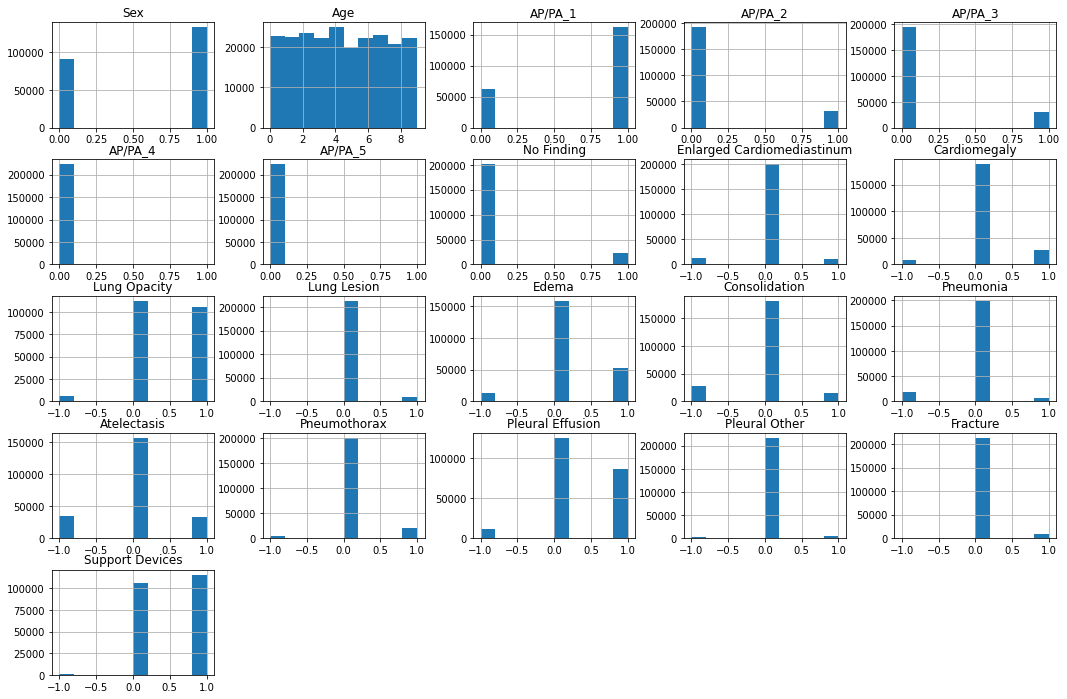

In [147]:
chexpert.hist(bins = 10, figsize=(18, 12))

## Dane zdjęciowe

### Przeprowadzone transformacje

In [3]:
class ImageResizer(TransformerMixin):
    def __init__(self, output_size):
        self.output_size = output_size
    def fit(self, X):
        return self
    def transform(self, X):
        X_new = deepcopy(X)
        for i in range(len(X)):
            if X[i].ndim == 3:
                X[i] = X[i][:, :, 0]
            X_new[i] = (skimage.transform.resize(X[i], self.output_size) * 255).astype('uint8')
        return X_new
    
class HistEqualizer(TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        pass
    def transform(self, X):
        X_new = deepcopy(X)
        for i in range(len(X)):
            if X[i].ndim == 3:
                X[i] = X[i][:, :, 0]
            X_new[i] = cv2.equalizeHist(X[i])
        return X_new

class TextRemover(TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
    def fit(self, X):
        return self
    def transform(self, X):
        X_new = deepcopy(X)
        for i in range(len(X)):
            if X[i].ndim == 3:
                X[i] = X[i][:, :, 0]
            mask = cv2.threshold(X[i], int(255*self.threshold), 255, cv2.THRESH_BINARY)[1]
            X_new[i] = cv2.inpaint(X[i], mask, 5, cv2.INPAINT_NS)
        return X_new

W ramach poprzednich prac domowych przekonaliśmy się, że istotnym problemem powtarzającym się w różnych bazach danych są litery występujące na zdjęciach. W związku z tym próbujemy usunąć, a przynajmniej znacznie zredukować częstość tego zjawiska poprzez wyodrębnienie maski z najjaśniejszych pikseli (wynika to z faktu, że litery, jak już zdążyliśmy się przekonać, zazwyczaj są białe i zapisane na czarnym tle).

Następnie ustalamy jeden wspólny rozmiar zdjęć. Ponieważ we wszystkich bazach danych poza bazami tekstowymi rozmiary zdjęć wahały się od $256 \times 256$ do $512 \times 512$, zmieniamy rozmiar wszystkich zdjęć na $512 \times 512$.

Na koniec stosujemy technikę wyrównywania histogramu.

In [4]:
image_pipeline = make_pipeline(
    TextRemover(0.95),
    ImageResizer((512, 512)),
    HistEqualizer()
)

### Przykład zastosowania

#### Załadowanie przykładowych zdjęć

In [5]:
data_src = "F:/wb/"
chexpert = pd.read_csv(data_src + "CheXpert-v1.0-small/train.csv")
chexpert['Patient'] = chexpert['Path'].str.split('/').apply(lambda x: x[2]).str.replace('patient', '')

In [6]:
src_list = (data_src + chexpert['Path'][76577:76581]).tolist() + \
    [data_src + f"covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-{i+1}.png" for i in range(5)]
src_list

['F:/wb/CheXpert-v1.0-small/train/patient18369/study1/view2_lateral.jpg',
 'F:/wb/CheXpert-v1.0-small/train/patient18369/study2/view1_frontal.jpg',
 'F:/wb/CheXpert-v1.0-small/train/patient18369/study2/view2_lateral.jpg',
 'F:/wb/CheXpert-v1.0-small/train/patient18370/study1/view1_frontal.jpg',
 'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png',
 'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-2.png',
 'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-3.png',
 'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-4.png',
 'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-5.png']

In [7]:
sample_images = [cv2.imread(src) for src in src_list]

In [8]:
#covid-19-segmentation-dataset
nii_img = nib.load("F:/wb/tr_im.nii.gz")
nii_data = nii_img.get_fdata()
for i in range(5):
    nii_img_temp = nii_data[:, :, i]
    sample_images.append(
        np.round(
            (nii_img_temp - nii_img_temp.min()) / (nii_img_temp.max() - nii_img_temp.min()) * 255
        ).astype('uint8')
    )

In [9]:
sample_images # zawierają po kilka zdjęć z każdej z trzech baz danych

[array([[[69, 69, 69],
         [65, 65, 65],
         [63, 63, 63],
         ...,
         [81, 81, 81],
         [85, 85, 85],
         [98, 98, 98]],
 
        [[65, 65, 65],
         [61, 61, 61],
         [59, 59, 59],
         ...,
         [72, 72, 72],
         [75, 75, 75],
         [88, 88, 88]],
 
        [[63, 63, 63],
         [59, 59, 59],
         [57, 57, 57],
         ...,
         [68, 68, 68],
         [71, 71, 71],
         [84, 84, 84]],
 
        ...,
 
        [[47, 47, 47],
         [41, 41, 41],
         [36, 36, 36],
         ...,
         [61, 61, 61],
         [64, 64, 64],
         [73, 73, 73]],
 
        [[49, 49, 49],
         [40, 40, 40],
         [33, 33, 33],
         ...,
         [62, 62, 62],
         [64, 64, 64],
         [74, 74, 74]],
 
        [[47, 47, 47],
         [36, 36, 36],
         [20, 20, 20],
         ...,
         [62, 62, 62],
         [64, 64, 64],
         [73, 73, 73]]], dtype=uint8),
 array([[[25, 25, 25],
         [23, 23, 2

In [10]:
transformation_results = image_pipeline.transform(sample_images)

#### Rezultaty

##### Przed

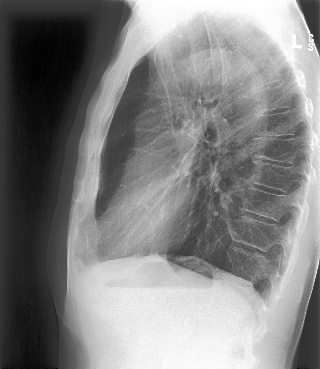

In [11]:
img_76577 = Image.open(src_list[0])
img_76577

##### Po

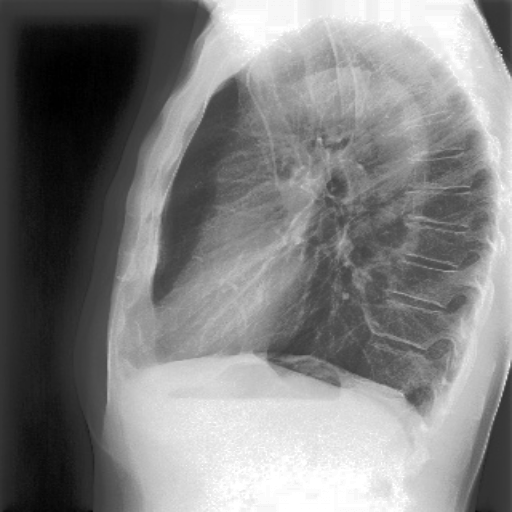

In [12]:
Image.fromarray(transformation_results[0])

Uzyskaliśmy pożądany rozmiar $512 \times 512$, a także pozbyliśmy się niechcianych liter (L, C, S). Udało się nam również wyrównać histogramy:

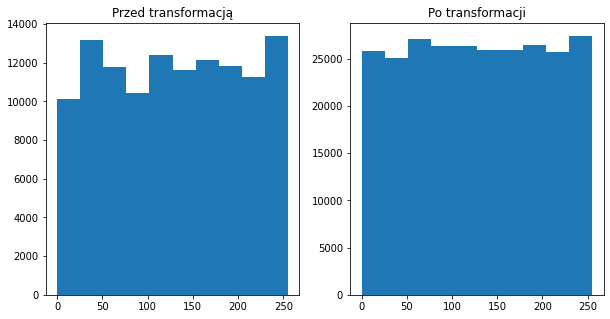

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(np.asarray(img_76577).flatten(), bins=10)
ax2.hist(transformation_results[0].flatten(), bins=10)
ax1.set_title('Przed transformacją')
ax2.set_title('Po transformacji')
plt.show()